## Initialization

In [1]:
from autograd import grad, hessian
import autograd.scipy.stats as st
from scipy.stats import levy_stable
import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from itertools import repeat
from functools import partial

sheet_url = "https://docs.google.com/spreadsheets/d/1_PTiZ1_faoUW4BjRaGA2rx39tGIK2ODa18FJyTHrZh0/edit#gid=0"
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(csv_export_url)

sheet_url_compute = "https://docs.google.com/spreadsheets/d/1_PTiZ1_faoUW4BjRaGA2rx39tGIK2ODa18FJyTHrZh0/edit#gid=1718304314"
csv_export_url_compute = sheet_url_compute.replace('/edit#gid=', '/export?format=csv&gid=')
df_compute = pd.read_csv(csv_export_url_compute)

sheet_url_runs = "https://docs.google.com/spreadsheets/d/1_PTiZ1_faoUW4BjRaGA2rx39tGIK2ODa18FJyTHrZh0/edit#gid=1742775451"
csv_export_url_runs = sheet_url_runs.replace('/edit#gid=', '/export?format=csv&gid=')
df_runs = pd.read_csv(csv_export_url_runs)

In [2]:
import re

history = []
date_value_pairs = []
date_value_pairs_runs = []
runs_dict = dict()
date_runs = []

for index, row in df.iterrows():
   datetime_object = datetime.strptime(row["Date"], "%Y‑%m‑%d")

   if pd.notnull(df.at[index, "Elo (single-thread)"]):
      elo_entry = row["Elo (single-thread)"]
      elo = float(re.split(': | ±', elo_entry)[1])
      history.append((datetime_object, elo))

   else:
      history.append((datetime_object, None))

for index, row in df_compute.iterrows():
   datetime_object = datetime.strptime(row["Date"], "%Y-%m-%d")
   date_value_pairs.append((datetime_object, float(row["CPU years (cumulative)"])))

for index, row in df_runs.iterrows():
   datetime_object = datetime.strptime(row["Date"], "%Y-%m-%d")
   date_value_pairs_runs.append((datetime_object, float(row["Test runs (cumulative)"])))
   runs_dict[datetime_object] = float(row["Test runs (cumulative)"])
   date_runs.append(datetime_object)

date_runs = sorted(date_runs)

In [3]:
history_normalized = []

prev_version_elo = 0
prev_elo = 0

for pair in history:
   (date_obj, elo) = pair

   if elo == None:
     prev_version_elo += prev_elo
   else:
     history_normalized.append((date_obj, elo + prev_version_elo))
     prev_elo = elo

print("Number of data points on Elo history: %d" % (len(history_normalized)))

Number of data points on Elo history: 258


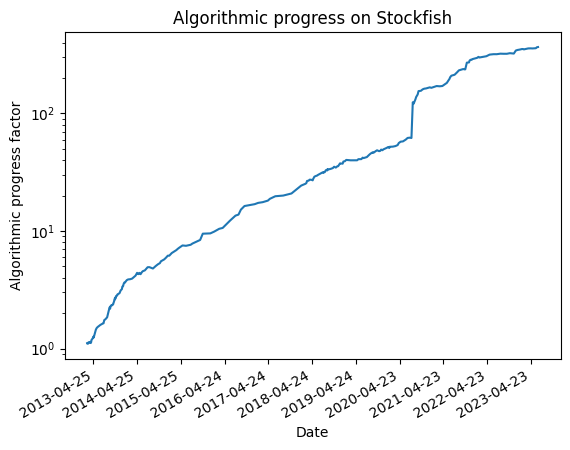

In [4]:
speedup_divisor_LTC = 142.987

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
plt.plot([pair[0] for pair in history_normalized],[np.exp(pair[1]/speedup_divisor_LTC) for pair in history_normalized])
plt.gcf().autofmt_xdate()

plt.yscale("log")
plt.ylabel("Algorithmic progress factor")
plt.xlabel("Date")
plt.title("Algorithmic progress on Stockfish")

plt.savefig("output_plot_stockfish.pdf")
plt.show()

In [5]:
initial_date = date_value_pairs_runs[0][0]
final_date = date_value_pairs_runs[-1][0]
runs_df_dict = {"Date": [], "Runs": []}

date = initial_date - timedelta(days=1)
current_cumulative_runs = 0

while date < final_date:
   next_date = date + timedelta(days=1)
   if date in runs_dict:
     current_cumulative_runs = runs_dict[date]

   if next_date in runs_dict:
    runs_df_dict["Runs"].append(runs_dict[next_date] - current_cumulative_runs)
   else:
    runs_df_dict["Runs"].append(0)

   runs_df_dict["Date"].append(next_date.strftime("%Y-%m-%d"))
   date = next_date

df_runs_intensity = pd.DataFrame(runs_df_dict)
df_runs_intensity.to_csv("runs_intensity_stockfish.csv")

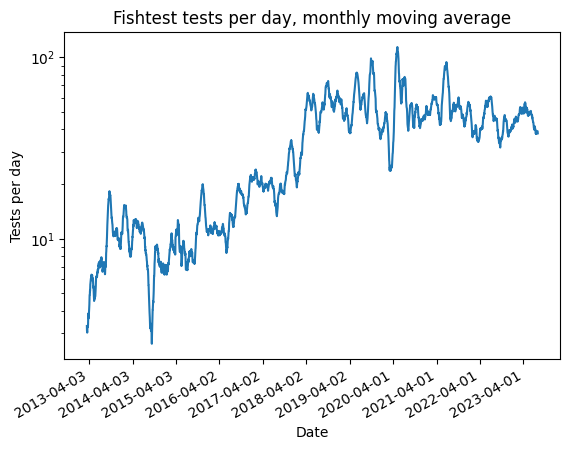

In [6]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))

cumulative_inputs = np.array([pair[1] for pair in date_value_pairs_runs])
#plt.plot([pair[0] for pair in date_value_pairs_runs][1:], cumulative_inputs[1:] - cumulative_inputs[:-1])
plt.plot([datetime.strptime(date_str, "%Y-%m-%d") for date_str in runs_df_dict["Date"][30:]], \
         [np.mean(runs_df_dict["Runs"][i:i+30]) for i in range(len(runs_df_dict["Runs"]) - 30)])
plt.gcf().autofmt_xdate()

plt.yscale("log")
plt.ylabel("Tests per day")
plt.xlabel("Date")
plt.title("Fishtest tests per day, monthly moving average")

plt.savefig("stockfish_tests_monthly_ma.pdf")
plt.show()

## Optimization

### Defining auxiliary functions

In [7]:
import bisect

def linear_interpolation(date_to_interpolate, date_value_pairs):
    # Make sure list is sorted by datetime
    date_value_pairs = sorted(date_value_pairs, key=lambda x: x[0])

    for i in range(len(date_value_pairs) - 1):
        current_date, current_value = date_value_pairs[i]
        next_date, next_value = date_value_pairs[i + 1]

        if current_date <= date_to_interpolate <= next_date:
            total_seconds = (next_date - current_date).total_seconds()
            elapsed_seconds = (date_to_interpolate - current_date).total_seconds()

            # Compute interpolated value
            interpolated_value = current_value + (next_value - current_value) * (elapsed_seconds / total_seconds)
            return interpolated_value

    return None  # The date_to_interpolate was not in the range of dates in the list

def compute_integral(t1, t2, date_value_pairs_local, lambda_val=1, dates=None):
  date_value_pairs_local = sorted(date_value_pairs_local, key=lambda x: x[0])
  prev_date = None
  integral = 0

  init_index = 0
  #if dates != None:
     #init_index = max(bisect.bisect_left(dates, t1) - 1, 0)

  for i in range(init_index, len(date_value_pairs_local) - 1):
      (current_date, current_value) = date_value_pairs_local[i]
      (next_date, next_value) = date_value_pairs_local[i + 1]

      if current_date <= t1 <= next_date and current_date <= t2 <= next_date:
          total_seconds = (next_date - current_date).total_seconds()
          elapsed_seconds = (t2 - t1).total_seconds()

          integral += elapsed_seconds * ((next_value - current_value)/total_seconds)**lambda_val
          break
      elif t1 <= current_date and t2 >= next_date:
          total_seconds = (next_date - current_date).total_seconds()
          integral += total_seconds * ((next_value - current_value)/total_seconds)**lambda_val
      elif t2 >= current_date and t2 <= next_date:
          total_seconds = (next_date - current_date).total_seconds()
          elapsed_seconds = (t2 - current_date).total_seconds()

          integral += elapsed_seconds * ((next_value - current_value)/total_seconds)**lambda_val
          break
      elif t1 <= next_date and t1 >= current_date:
          total_seconds = (next_date - current_date).total_seconds()
          elapsed_seconds = (next_date - t1).total_seconds()

          integral += elapsed_seconds * ((next_value - current_value)/total_seconds)**lambda_val
      else:
          continue

  return integral

def norm_logpdf(x, mu=0, sigma=1):
    n = len(x)
    return -np.sum(np.log(sigma)) - n * np.log(2*np.pi)/2 - (1/2) * np.sum(((x - mu)/sigma)**2)

def norm_logpdf_scalar(x, mu=0, sigma=1):
    return -np.log(sigma) - np.log(2*np.pi)/2 - (1/2) * ((x - mu)/sigma)**2

def sigmoid(x):
    if x > 20:
      return 1
    elif x < -20:
      return 0
    else:
      return 1/(1 + np.exp(-x))

### Defining the negative log likelihood function

In [10]:
speedup_divisor_LTC = 142.987
np.seterr(all='raise')

likelihood_divisor = 1000

start_date_global = datetime.strptime("2013-04-25", "%Y-%m-%d")
end_date_global = datetime.strptime("2023-04-25", "%Y-%m-%d")

def custom_cdf(x, phi, shift, loc, scale):
  return st.norm.cdf(x**phi - shift**phi, loc=loc, scale=scale)

custom_pdf = grad(custom_cdf)

def custom_logpdf_t(x, phi, shift, loc, scale, df):
  return np.log(phi) + (phi-1)*np.log(x) + st.t.logpdf(x**phi - shift**phi, df, loc, scale)

def custom_logpdf(x, phi, shift, loc, scale):
  return np.log(phi) + (phi-1)*np.log(x) + norm_logpdf_scalar(x**phi, loc + shift**phi, scale)

def custom_logpdf_levy(x, phi, loc, scale, alpha, beta):
  if alpha == 2:
    return np.log(np.abs(phi)) + (phi-1)*np.log(x) + norm_logpdf_scalar(x**phi, loc, scale)
  else:
    return np.log(np.abs(phi)) + (phi-1)*np.log(x) + levy_stable.logpdf(x**phi, alpha, beta, loc = loc, scale = scale)

def parameter_transform(params):
   phi, lambda_val = params[:2]
   delta, sigma = np.exp(params[2:4])
   alpha = 1 + sigmoid(params[4])
   beta = 2 * sigmoid(params[5]) - 1

   return phi, lambda_val, delta, sigma, alpha, beta

def negative_log_likelihood(params, output_pair_indices):
  phi, lambda_val = params[:2]
  delta, sigma = np.exp(params[2:4])
  alpha = 1 + sigmoid(params[4])
  beta = 2 * sigmoid(params[5]) - 1

  noise_exponent = phi - phi/alpha

  result = 0

  for i in output_pair_indices:
      (current_date, current_value) = history_normalized[i]
      (next_date, next_value) = history_normalized[i + 1]

      if current_date == next_date:
         continue

      if next_date > date_value_pairs_runs[-1][0]:
         break

      current_compute_eq = np.exp(current_value/speedup_divisor_LTC)
      next_compute_eq = np.exp(next_value/speedup_divisor_LTC)

      time_elapsed = (next_date - current_date).total_seconds()

      integral = compute_integral(current_date, next_date, date_value_pairs_runs.copy(), lambda_val, date_runs)
      #integral_alpha = compute_integral(current_date, next_date, date_value_pairs_runs.copy(), lambda_val*alpha, date_runs)
      #print(current_date, next_date, integral)
      result -= custom_logpdf_levy(next_compute_eq, phi, current_compute_eq**phi + delta*phi*integral, sigma * current_compute_eq**noise_exponent * integral**(1/alpha), alpha, beta)

  return result/likelihood_divisor

### Defining the optimization callback function

In [11]:
from scipy.optimize import minimize

np.seterr(all="raise")

x0 = [1, 0, -15, -10, 2, 0]

#x0 = best_params.copy()
#default_indices = random_indices[2].copy()
len_indices = len(history_normalized)-1

def callbackF(Xi):
    global Nfeval, fun_last
    fun = negative_log_likelihood(Xi, default_indices)

    if len(holdout_indices) > 0:
      fun_holdout = negative_log_likelihood(Xi, holdout_indices)

    if fun != fun_last:
      Xf = parameter_transform(Xi.copy())

      if len(holdout_indices) > 0:
        print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}   {6: 3.6f}   log likelihood: {7: 3.6f}   holdout log likelihood: {8: 3.6f}'.format(Nfeval, Xf[0], Xf[1], Xf[2], Xf[3], \
                                                                                                                                                            Xf[4], Xf[5], -likelihood_divisor*fun, -likelihood_divisor*fun_holdout))
      else:
        print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}   {6: 3.6f}   log likelihood: {7: 3.6f}'.format(Nfeval, Xf[0], Xf[1], Xf[2], Xf[3], \
                                                                                                                          Xf[4], Xf[5], -likelihood_divisor*fun))
      Nfeval += 1
      fun_last = fun

### Performing the optimization without a validation set

In [12]:
default_indices = range(len_indices)
holdout_indices = []

print("Optimizing without lambda:")

Nfeval = 1
fun_last = None
res_no_lambda = minimize(negative_log_likelihood, x0=x0, args=(default_indices), \
                        callback=callbackF, method="SLSQP", tol=1e-9, constraints=({"type": "eq", "fun": lambda x: x[1]}))
print(res_no_lambda)

if len(holdout_indices) > 0:
  no_lambda_holdout_llf = -likelihood_divisor*negative_log_likelihood(res_no_lambda.x, holdout_indices)
  print("Holdout log likelihood: %.6f" % (no_lambda_holdout_llf))

print("\nOptimizing with lambda:")

Nfeval = 1
fun_last = None
res = minimize(negative_log_likelihood, x0=x0, args=(default_indices), \
               callback=callbackF, method="SLSQP", tol=1e-9)
print(res)

if len(holdout_indices) > 0:
  lambda_holdout_llf = -likelihood_divisor*negative_log_likelihood(res.x, holdout_indices)
  print("Holdout log likelihood: %.6f" % (lambda_holdout_llf))

#print("\nOptimizing with lambda and without the three outlier (NNUE) indices in 2020:")

#Nfeval = 1
#fun_last = None

#outlier_indices = [193, 194, 195]
#res_no_nnue = minimize(negative_log_likelihood, x0=x0, args=[i for i in (range(len(history_normalized)-1)) if i not in outlier_indices], \
#               callback=callbackF, method="SLSQP")
#print(res_no_nnue)

Optimizing without lambda:
   1    0.603088    0.000000    0.000000    0.000055    1.872115    0.006941   log likelihood: -427.763124
   2    0.867860    0.000000    0.000000    0.000051    1.874971    0.008899   log likelihood: -326.683741
   3    0.883615    0.000000    0.000000    0.000051    1.872940    0.021580   log likelihood: -314.142830
   4    0.870865    0.000000    0.000000    0.000049    1.872155    0.037729   log likelihood: -306.204360
   5    0.829915    0.000000    0.000000    0.000043    1.872637    0.065884   log likelihood: -296.707259
   6    0.748385    0.000000    0.000000    0.000033    1.875313    0.110641   log likelihood: -285.374666
   7    0.622490    0.000000    0.000000    0.000022    1.880610    0.171039   log likelihood: -274.477821
   8    0.510767    0.000000    0.000000    0.000015    1.886144    0.219325   log likelihood: -268.646166
   9    0.445972    0.000000    0.000000    0.000012    1.890317    0.242894   log likelihood: -265.408487
  10    0.

### Performing the optimization with a validation set (holdout indices)

In [13]:
perform_holdout_optimization = True

if perform_holdout_optimization:
  default_indices_h = range(int(len_indices*(4/5)))
  holdout_indices_h = range(int(len_indices*(4/5)), len_indices)

  print("Optimizing without lambda:")

  Nfeval = 1
  fun_last = None
  res_no_lambda_h = minimize(negative_log_likelihood, x0=x0, args=(default_indices_h), \
                            callback=callbackF, method="SLSQP", tol=1e-9, constraints=({"type": "eq", "fun": lambda x: x[1]}))
  print(res_no_lambda_h)

  if len(holdout_indices_h) > 0:
    no_lambda_holdout_llf = -likelihood_divisor*negative_log_likelihood(res_no_lambda_h.x, holdout_indices_h)
    print("Holdout log likelihood: %.6f" % (no_lambda_holdout_llf))

  print("\nOptimizing with lambda:")

  Nfeval = 1
  fun_last = None
  res_h = minimize(negative_log_likelihood, x0=x0, args=(default_indices_h), \
                  callback=callbackF, method="SLSQP", tol=1e-9)
  print(res_h)

  if len(holdout_indices_h) > 0:
    lambda_holdout_llf = -likelihood_divisor*negative_log_likelihood(res_h.x, holdout_indices_h)
    print("Holdout log likelihood: %.6f" % (lambda_holdout_llf))

#print("\nOptimizing with lambda and without the three outlier (NNUE) indices in 2020:")

#Nfeval = 1
#fun_last = None

#outlier_indices = [193, 194, 195]
#res_no_nnue = minimize(negative_log_likelihood, x0=x0, args=[i for i in (range(len(history_normalized)-1)) if i not in outlier_indices], \
#               callback=callbackF, method="SLSQP")
#print(res_no_nnue)

Optimizing without lambda:
   1    0.880057    0.000000    0.000000    0.000051    1.875179    0.004209   log likelihood: -329.856767
   2    0.962160    0.000000    0.000000    0.000053    1.873552    0.009480   log likelihood: -327.169418
   3    0.983880    0.000000    0.000000    0.000053    1.872631    0.016711   log likelihood: -326.459694
   4    0.971979    0.000000    0.000000    0.000051    1.872355    0.027820   log likelihood: -320.988972
   5    0.926535    0.000000    0.000000    0.000046    1.873524    0.047539   log likelihood: -310.794475
   6    0.833263    0.000000    0.000000    0.000037    1.877491    0.080997   log likelihood: -296.011721
   7    0.679692    0.000000    0.000000    0.000025    1.885302    0.131320   log likelihood: -279.329624
   8    0.536800    0.000000    0.000000    0.000017    1.893705    0.176802   log likelihood: -270.098526
   9    0.462542    0.000000    0.000000    0.000013    1.899403    0.199492   log likelihood: -266.127218
  10    0.

### Optimization results

Store a copy of the optimal parameters.

In [15]:
best_params = res.x.copy()
print(best_params)

[  0.47639983   0.39314262 -13.14510952 -10.20901094   1.04495843
   7.30144928]


Perform a likelihood ratio test to check if the better fit of the model with variable lambda is statistically significant.

In [14]:
print("Holdout log likelihood differential in favor of the model with lambda freely varying: %.6f" % (lambda_holdout_llf - no_lambda_holdout_llf))

Holdout log likelihood differential in favor of the model with lambda freely varying: 2.789957


In [17]:
from scipy.stats import chi2

log_likelihood_without_lambda = -likelihood_divisor*res_no_lambda.fun
log_likelihood_with_lambda = -likelihood_divisor*res.fun

print("Likelihood ratio test p-value: %.2e" % (chi2.sf(2 * (log_likelihood_with_lambda - log_likelihood_without_lambda), 1)))

Likelihood ratio test p-value: 4.13e-03


## Simulations with the optimal solution

In [18]:
def plot_results(phi, lambda_val, delta):
  #noise_exponent = 1
  #lambda_val = 0

  x = []
  y = []
  cumulative_effort = 0

  for i in range(30, len(date_value_pairs_runs) - 50):
      (current_date, current_compute) = date_value_pairs_runs[i]
      (next_date, next_compute) = date_value_pairs_runs[i + 1]

      if current_date == next_date:
         continue

      total_seconds = (next_date - current_date).total_seconds()
      integral = total_seconds * ((next_compute - current_compute)/total_seconds)**lambda_val
      cumulative_effort += integral

      current_compute_eq = np.exp(linear_interpolation(current_date, history_normalized)/speedup_divisor_LTC)
      #print(next_date)
      next_compute_eq = np.exp(linear_interpolation(next_date, history_normalized)/speedup_divisor_LTC)

      x.append((delta*phi*cumulative_effort + 1)**(1/phi))
      y.append(next_compute_eq)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
  plt.plot([pair[0] for pair in history_normalized],[np.exp(pair[1]/speedup_divisor_LTC) for pair in history_normalized])
  plt.plot([pair[0] for pair in date_value_pairs_runs[30:-49]], np.array([1] + x), color="red")

  plt.gcf().autofmt_xdate()

  plt.yscale("log")
  plt.ylabel("Algorithmic progress factor")
  plt.xlabel("Date")
  plt.title("Algorithmic progress on Stockfish")

  plt.savefig("stockfish_model.pdf")
  plt.show()

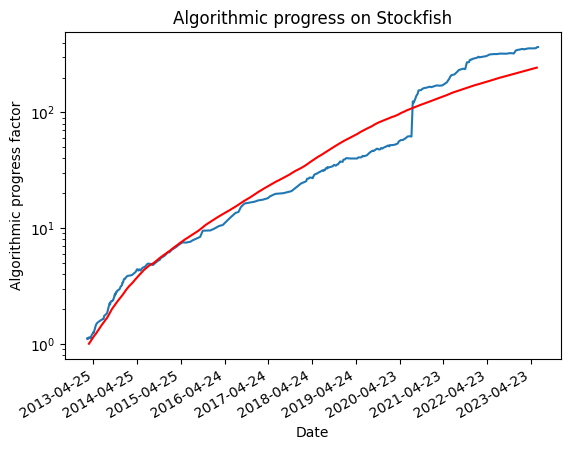

In [19]:
plot_results(*parameter_transform(res.x)[:3])

In [20]:
def simulate_levy_distribution(params, initial_date, final_date):
   phi, lambda_val, delta, sigma, alpha, beta = parameter_transform(params)

   date = initial_date
   alg_progress = np.exp(linear_interpolation(initial_date, history_normalized)/speedup_divisor_LTC)
   alg_list = [alg_progress]
   date_list = [date]

   while date < final_date:
     next_date = date + timedelta(days=14)
     integral = compute_integral(date, next_date, date_value_pairs_runs.copy(), lambda_val, date_runs)
     # integral_alpha = compute_integral(date, next_date, date_value_pairs_runs.copy(), lambda_val*alpha, date_runs)

     alg_progress = (alg_progress**phi + delta*phi*integral + sigma*alg_progress**(phi*(1 - 1/alpha)) * integral**(1/alpha) * levy_stable.rvs(alpha, beta))**(1/phi)
     alg_list.append(alg_progress)
     date_list.append(next_date)

     date = next_date

   return date_list, alg_list

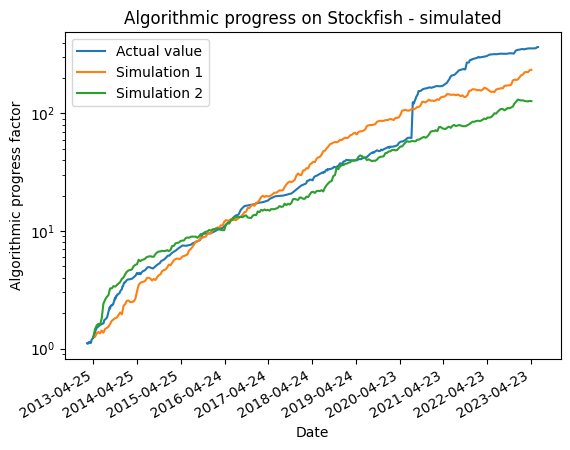

In [21]:
#x, y = simulate_levy_distribution(res.x, datetime.strptime("2013-04-25", "%Y-%m-%d"), datetime.strptime("2023-04-25", "%Y-%m-%d"))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))

plt.gcf().autofmt_xdate()
plt.plot([pair[0] for pair in history_normalized],[np.exp(pair[1]/speedup_divisor_LTC) for pair in history_normalized], label="Actual value")

np.random.seed(42)

for i in range(2):
   x, y = simulate_levy_distribution(res.x, datetime.strptime("2013-04-25", "%Y-%m-%d"), datetime.strptime("2023-04-25", "%Y-%m-%d"))
   plt.plot(x, y, label="Simulation " + str(i+1))

plt.yscale("log")
plt.ylabel("Algorithmic progress factor")
plt.xlabel("Date")
plt.title("Algorithmic progress on Stockfish - simulated")
plt.legend()

plt.savefig("simulations_stockfish.pdf")
plt.show()

### Linear regression

In [23]:
import statsmodels.api as sm

endog = np.array([np.log((history_normalized[i+10][1] - history_normalized[i][1]) \
                         /((history_normalized[i+10][0] - history_normalized[i][0]).total_seconds() * speedup_divisor_LTC)) for i in range(len(history_normalized) - 10)])
exog = np.stack(([history_normalized[i][1]/speedup_divisor_LTC for i in range(len(history_normalized) - 10)], \
                  [np.log(compute_integral(history_normalized[i][0], history_normalized[i+10][0], date_value_pairs_runs, lambda_val=1) \
                          /(history_normalized[i+10][0] - history_normalized[i][0]).total_seconds()) \
                   for i in range(len(history_normalized) - 10)]))

np.shape(endog)
model_regression = sm.OLS(endog=endog, exog=sm.add_constant(np.transpose(exog)))
res_regression = model_regression.fit()
print(res_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     59.59
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           8.17e-22
Time:                        21:56:40   Log-Likelihood:                -238.05
No. Observations:                 248   AIC:                             482.1
Df Residuals:                     245   BIC:                             492.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.5784      0.909    -16.043      0.0

## Bootstrapping for standard errors

In [24]:
np.random.seed(42)
np.seterr(all="warn")

num_bootstrap = 100
sampled_params = []
random_index_list = []
x0 = res.x

for i in range(num_bootstrap):
   random_indices = np.random.randint(0, len(history_normalized)-1, size=len(history_normalized)-1)

   res_bootstrap = minimize(negative_log_likelihood, x0=x0, args=(random_indices), \
                 method="SLSQP")
   sampled_params.append(res_bootstrap.x)
   random_index_list.append(random_indices)

   print("%dth bootstrap complete!" % (i+1), parameter_transform(res_bootstrap.x))

1th bootstrap complete! (0.3671308725398505, 0.21319220751813384, 3.540107937514045e-07, 4.287446568910039e-06, 1.5726153317713396, 0.9986683077376779)
2th bootstrap complete! (0.4982687308720806, 0.3773887835130569, 1.9128875581300398e-06, 3.842738898083316e-05, 1.7323664229568831, 0.9986519238541618)
3th bootstrap complete! (0.6963507686159055, 0.7584449918125777, 8.224039504755204e-05, 0.0004596355124170625, 1.7259074341907688, 0.9986648299834262)
4th bootstrap complete! (0.4228936795587336, 0.4066555903364152, 2.003487603207881e-06, 3.583403870455067e-05, 1.7419527945253703, 0.9986519137298175)
5th bootstrap complete! (0.501022301081662, 0.39441046307200517, 1.9159393713559706e-06, 3.7248108589330974e-05, 1.736481669895374, 0.9986519256986752)
6th bootstrap complete! (0.49142345083295935, 0.3627858867066208, 1.570334104110391e-06, 4.401978219985411e-05, 1.8115772436672568, 0.9986529786865492)
7th bootstrap complete! (0.5039223504201142, 0.37766030594278677, 1.7887002262976128e-06, 

In [25]:
phi_vals = [pi[0] for pi in sampled_params]
lambda_vals = [pi[1] for pi in sampled_params]
r_vals = [pi[1]/pi[0] for pi in sampled_params]
r_vals_pos_lambda = [r_vals[i] for i in range(len(r_vals)) if lambda_vals[i] > 0]

print("Beta: \t\t%.3f (%.3f)" % (np.median(phi_vals), np.std(phi_vals)))
print("Lambda: \t%.3f (%.3f)" % (np.median(lambda_vals), np.std(lambda_vals)))
print("Returns: \t%.3f (%.3f)" % (np.median(r_vals), np.std(r_vals)))
#print("Returns (lambda > 0): \t%.3f (%.3f)" % (np.median(r_vals_pos_lambda), np.std(r_vals_pos_lambda)))

Beta: 		0.476 (0.067)
Lambda: 	0.397 (0.081)
Returns: 	0.832 (0.151)


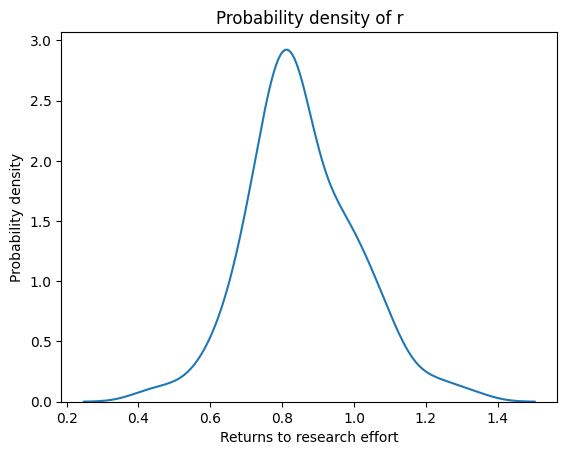

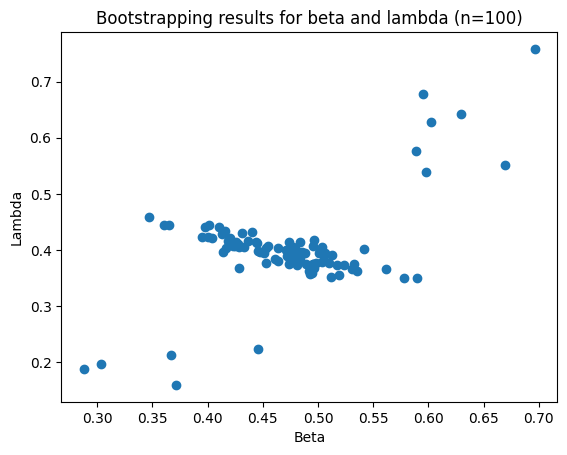

In [26]:
import seaborn as sns

fig, ax = plt.subplots()
sns.kdeplot([r_vals[i] for i in range(len(r_vals))], ax=ax)

plt.xlabel("Returns to research effort")
plt.ylabel("Probability density")

plt.title("Probability density of r")

plt.savefig("returns_density_stockfish.pdf")
plt.show()

plt.scatter(phi_vals, lambda_vals)
plt.xlabel("Beta")
plt.ylabel("Lambda")
plt.title("Bootstrapping results for beta and lambda (n=%d)" % (num_bootstrap))

plt.savefig("bootstrap_stockfish.pdf")
plt.show()

Save the sampled random indices and parameters into pickle files so that the results can be reproduced later.

In [27]:
import pickle

with open("sampled_params_100.pickle", "wb") as f:
  pickle.dump(sampled_params, f)

with open("random_indices_100.pickle", "wb") as f:
  pickle.dump(random_index_list, f)